# Step1

In [1]:
#download diabetes.csv from google drive
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# 1. Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

# 2. Download actual file
file_patients = drive.CreateFile({'id': '1oo-SD-iX2-Vuq1_fH7vXLpIggdSEz7m3'})
file_patients.GetContentFile('diabetes.csv')

!ls

     |████████████████████████████████| 993kB 5.0MB/s 
adc.json  diabetes.csv	sample_data


## a

In [2]:
# Read the csv file as pandas dataframe
import pandas as pd
df = pd.read_csv('diabetes.csv')
# Print
print(df.info())
# Print the column names
print(df.columns.values)
# Print some summary stats about the data
print(df.describe())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 101766 entries, 0 to 101765
Data columns (total 50 columns):
encounter_id                101766 non-null int64
patient_nbr                 101766 non-null int64
race                        101766 non-null object
gender                      101766 non-null object
age                         101766 non-null object
weight                      101766 non-null object
admission_type_id           101766 non-null int64
discharge_disposition_id    101766 non-null int64
admission_source_id         101766 non-null int64
time_in_hospital            101766 non-null int64
payer_code                  101766 non-null object
medical_specialty           101766 non-null object
num_lab_procedures          101766 non-null int64
num_procedures              101766 non-null int64
num_medications             101766 non-null int64
number_outpatient           101766 non-null int64
number_emergency            101766 non-null int64
number_inpatient            10176

##b

In [3]:
# Drop all duplicates record of individual patient
df = df.drop_duplicates(subset=['patient_nbr'], keep='first')
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 71518 entries, 0 to 101765
Data columns (total 50 columns):
encounter_id                71518 non-null int64
patient_nbr                 71518 non-null int64
race                        71518 non-null object
gender                      71518 non-null object
age                         71518 non-null object
weight                      71518 non-null object
admission_type_id           71518 non-null int64
discharge_disposition_id    71518 non-null int64
admission_source_id         71518 non-null int64
time_in_hospital            71518 non-null int64
payer_code                  71518 non-null object
medical_specialty           71518 non-null object
num_lab_procedures          71518 non-null int64
num_procedures              71518 non-null int64
num_medications             71518 non-null int64
number_outpatient           71518 non-null int64
number_emergency            71518 non-null int64
number_inpatient            71518 non-null int64
di

##c

In [4]:
# Drop patients who can not be readmitted
pts = df[df['discharge_disposition_id'] != 11]
pts.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 70441 entries, 0 to 101765
Data columns (total 50 columns):
encounter_id                70441 non-null int64
patient_nbr                 70441 non-null int64
race                        70441 non-null object
gender                      70441 non-null object
age                         70441 non-null object
weight                      70441 non-null object
admission_type_id           70441 non-null int64
discharge_disposition_id    70441 non-null int64
admission_source_id         70441 non-null int64
time_in_hospital            70441 non-null int64
payer_code                  70441 non-null object
medical_specialty           70441 non-null object
num_lab_procedures          70441 non-null int64
num_procedures              70441 non-null int64
num_medications             70441 non-null int64
number_outpatient           70441 non-null int64
number_emergency            70441 non-null int64
number_inpatient            70441 non-null int64
di

# Step2

## d

In [5]:
# Add a new column for HbA1c
import numpy as np
pts['HbA1c'] = np.where(pts['A1Cresult']!='None', True, False)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


## e

In [6]:
# Add a new column for discharge_home
pts['discharge_home'] = np.where(pts['discharge_disposition_id']==1, True, False)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


## f

In [7]:
# Add a new column for emergency
pts['emergency'] = np.where(pts['admission_type_id'].isin((1, 2, 7)), True, False)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


## g

In [8]:
# Define a function to parse out the ICD codes
def diag_category(row):
  """ Computes a category for a diagnostic code, 0-8 or -1 if unknown """
  p = row['diag_1']
  if 'V' in p or 'E' in p:
    return 0
  else:
    try:
      p = float(p)
    except ValueError:
      return -1
    if (p >= 390 and p < 460) or (np.floor(p) == 785):
        return 1
    elif (p >= 460 and p < 520) or (np.floor(p) == 786):
        return 2
    elif (p >= 520 and p < 580) or (np.floor(p) == 787):
        return 3
    elif (np.floor(p) == 250):
        return 4
    elif (p >= 800 and p < 1000):
        return 5
    elif (p >= 710 and p < 740):
        return 6
    elif (p >= 580 and p < 630) or (np.floor(p) == 788):
        return 7
    elif (p >= 140 and p < 240):
        return 8
    else:
        return 0

# Add a new column for diagnosis
pts['diagnosis'] = df.apply(diag_category, axis=1)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


## h

In [9]:
# Add a new column for output
pts['output'] = np.where(pts['readmitted']!='NO', True, False)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


### Save our feature data to a processed csv file

In [10]:
subset = pts[['HbA1c','race','age','discharge_home','emergency','diagnosis',
             'time_in_hospital','output']]
print(subset.head())

   HbA1c             race      age  ...  diagnosis  time_in_hospital  output
0  False        Caucasian   [0-10)  ...          4                 1   False
1  False        Caucasian  [10-20)  ...          0                 3    True
2  False  AfricanAmerican  [20-30)  ...          0                 2   False
3  False        Caucasian  [30-40)  ...          0                 2   False
4  False        Caucasian  [40-50)  ...          8                 1   False

[5 rows x 8 columns]


In [0]:
# produce the whole file and download / check it
subset.to_csv('processed.csv')
# downloads the file to your local machine
from google.colab import files
files.download('processed.csv')

# Step3

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False): 0.588780
              precision    recall  f1-score   support

           0       0.60      0.95      0.73     10489
           1       0.44      0.06      0.11      7122

    accuracy                           0.59     17611
   macro avg       0.52      0.50      0.42     17611
weighted avg       0.53      0.59      0.48     17611



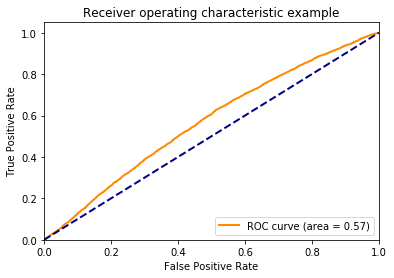

In [12]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn import neighbors, svm, calibration, tree, ensemble
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt

#need to recode some variables to handle categorical input so it is not treated
# as continuous
subset_cat = subset.select_dtypes(exclude=['number']).apply(LabelEncoder().fit_transform).join(subset.select_dtypes(include=['number']))
data = pd.get_dummies(subset_cat, columns=['race','diagnosis'])

X_train, X_test, y_train, y_test = train_test_split(data.drop(['output'], axis=1), data['output'], random_state=0, test_size=0.25)

def test_model(model):
  model.fit(X_train, y_train)
  y_predict = model.predict(X_test)
  print("%s: %f" % (str(model), metrics.accuracy_score(y_test, y_predict)))
  print(metrics.classification_report(y_test, y_predict))
  y_predict_proba = model.predict_proba(X_test)
  
  fpr, tpr, _ = metrics.roc_curve(y_test, y_predict_proba[:,1])
  roc_auc = metrics.auc(fpr, tpr)
  
  plt.figure()
  lw = 2
  plt.plot(fpr, tpr, color='darkorange',
           lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
  plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
  plt.xlim([0.0, 1.0])
  plt.ylim([0.0, 1.05])
  plt.xlabel('False Positive Rate')
  plt.ylabel('True Positive Rate')
  plt.title('Receiver operating characteristic example')
  plt.legend(loc="lower right")
  plt.show()
  
test_model(LogisticRegression())


# Step4

## Adding features

In [13]:
# Add a new column for serum glucose
pts['glucose_serum'] = np.where(pts['max_glu_serum']!='None', True, False)
pts['admission_urgent'] = np.where(pts['admission_type_id'].isin((1,2)), True, False)


subset2 = pts[['HbA1c','glucose_serum','race','age','gender','emergency',
               'admission_urgent','discharge_home','diagnosis','number_diagnoses',
               'time_in_hospital','number_inpatient','number_outpatient',
               'number_emergency','output']]

# produce the whole file and download / check it
subset2.to_csv('processed2.csv')
# downloads the file to your local machine
files.download('processed2.csv')

#need to recode some variables to handle categorical input so it is not treated
# as continuous
subset_cat = subset2.select_dtypes(exclude=['number']).apply(LabelEncoder().fit_transform).join(subset2.select_dtypes(include=['number']))
data = pd.get_dummies(subset_cat, columns=['race','diagnosis'])
X_train, X_test, y_train, y_test = train_test_split(data.drop(['output'], axis=1), data['output'], random_state=0, test_size=0.25)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


## Feature selection

### Model based feature selection

In [0]:
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_curve, auc
from scipy import interp

def choose_model(model, X, y, show_plot=True):
  cv = StratifiedKFold(n_splits=5)
  tprs = []
  aucs = []
  mean_fpr = np.linspace(0, 1, 100)

  i = 0
  for train, test in cv.split(X, y):
      probas_ = model.fit(X[train], y[train]).predict_proba(X[test])
      # Compute ROC curve and area the curve
      fpr, tpr, thresholds = roc_curve(y[test], probas_[:, 1])
      tprs.append(interp(mean_fpr, fpr, tpr))
      tprs[-1][0] = 0.0
      roc_auc = auc(fpr, tpr)
      aucs.append(roc_auc)
      if show_plot:
        plt.plot(fpr, tpr, lw=1, alpha=0.3,
                 label='ROC fold %d (AUC = %0.2f)' % (i, roc_auc))
      i += 1

  mean_tpr = np.mean(tprs, axis=0)
  mean_tpr[-1] = 1.0
  mean_auc = auc(mean_fpr, mean_tpr)
  std_auc = np.std(aucs)

  std_tpr = np.std(tprs, axis=0)
  tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
  tprs_lower = np.maximum(mean_tpr - std_tpr, 0)

  if show_plot:
    plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
             label='Luck', alpha=.8)
    plt.plot(mean_fpr, mean_tpr, color='b',
             label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),
             lw=2, alpha=.8)
    plt.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,
                     label=r'$\pm$ 1 std. dev.')

    plt.xlim([-0.05, 1.05])
    plt.ylim([-0.05, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic example')
    plt.legend(loc="lower right")
    plt.show()
  
  print('Mean ROC (AUC = %0.8f +- %0.8f)' % (mean_auc, std_auc))

In [15]:
from sklearn.feature_selection import RFE

rfe = RFE(estimator=LogisticRegression(solver='lbfgs', max_iter=10000), n_features_to_select=1, step=1)
rfe.fit(X_train.values, y_train.values)
print(rfe.ranking_)

feature_names = X_train.columns.values
print(feature_names)
print(sorted(zip(map(lambda x: round(x, 4), rfe.ranking_), feature_names)))

for i in range(len(feature_names)-1, 1, -1):
  # use the rfe order to select features and then test it
  rfe = RFE(estimator=LogisticRegression(solver='lbfgs', max_iter=10000), n_features_to_select=i-1, step=1)
  rfe.fit(X_train.values, y_train.values)
  selected = [name for rank, name in zip(map(lambda x: round(x, 4), rfe.ranking_), feature_names) if rank == 1]
  subset = X_train[selected]
  print(selected,end='')
  choose_model(LogisticRegression(solver='lbfgs', max_iter=10000), subset.values, y_train.values, False)

[21 15 20 23  2  1 11 17 27  3 18  7  5 28  4 26 10  8  9 24 13 14 25 12
 16 19 22  6]
['HbA1c' 'glucose_serum' 'age' 'gender' 'emergency' 'admission_urgent'
 'discharge_home' 'number_diagnoses' 'time_in_hospital' 'number_inpatient'
 'number_outpatient' 'number_emergency' 'race_0' 'race_1' 'race_2'
 'race_3' 'race_4' 'race_5' 'diagnosis_-1' 'diagnosis_0' 'diagnosis_1'
 'diagnosis_2' 'diagnosis_3' 'diagnosis_4' 'diagnosis_5' 'diagnosis_6'
 'diagnosis_7' 'diagnosis_8']
[(1, 'admission_urgent'), (2, 'emergency'), (3, 'number_inpatient'), (4, 'race_2'), (5, 'race_0'), (6, 'diagnosis_8'), (7, 'number_emergency'), (8, 'race_5'), (9, 'diagnosis_-1'), (10, 'race_4'), (11, 'discharge_home'), (12, 'diagnosis_4'), (13, 'diagnosis_1'), (14, 'diagnosis_2'), (15, 'glucose_serum'), (16, 'diagnosis_5'), (17, 'number_diagnoses'), (18, 'number_outpatient'), (19, 'diagnosis_6'), (20, 'age'), (21, 'HbA1c'), (22, 'diagnosis_7'), (23, 'gender'), (24, 'diagnosis_0'), (25, 'diagnosis_3'), (26, 'race_3'), (27,

#### ['HbA1c', 'glucose_serum', 'age', 'gender', 'emergency', 'admission_urgent', 'discharge_home', 'number_diagnoses', 'number_inpatient', 'number_outpatient', 'number_emergency', 'race_0', 'race_2', 'race_3', 'race_4', 'race_5', 'diagnosis_-1', 'diagnosis_0', 'diagnosis_1', 'diagnosis_2', 'diagnosis_3', 'diagnosis_4', 'diagnosis_5', 'diagnosis_6', 'diagnosis_7', 'diagnosis_8']Mean ROC (AUC = 0.61932995 +- 0.00438998)

The feature combination including all the features I selected above gives almost the highest AUC.
So I will use these features with different models to make the prediction.

## Predicting using different model with features selected. 
(random forests give an AUC of 0.63)

In [0]:
subset3 = pts[['HbA1c','glucose_serum','race','age','gender','emergency','time_in_hospital',
               'admission_urgent','discharge_home','diagnosis','number_diagnoses',
               'number_inpatient','number_outpatient','number_emergency','output']]

# produce the whole file and download / check it
subset3.to_csv('processed3.csv')
# downloads the file to your local machine
files.download('processed3.csv')

#need to recode some variables to handle categorical input so it is not treated
# as continuous
subset_cat = subset3.select_dtypes(exclude=['number']).apply(LabelEncoder().fit_transform).join(subset3.select_dtypes(include=['number']))
data = pd.get_dummies(subset_cat, columns=['race','diagnosis'])
X_train, X_test, y_train, y_test = train_test_split(data.drop(['output'], axis=1), data['output'], random_state=0, test_size=0.25)

### Logistic regression

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False): 0.619442
              precision    recall  f1-score   support

           0       0.62      0.91      0.74     10489
           1       0.59      0.20      0.30      7122

    accuracy                           0.62     17611
   macro avg       0.61      0.55      0.52     17611
weighted avg       0.61      0.62      0.56     17611



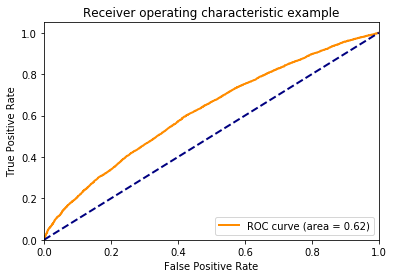

In [27]:
# Logistic regression with all features selected
test_model(LogisticRegression())

### Decision tree

In [0]:
from sklearn.model_selection import GridSearchCV
# First I will define two functions to help me get the optimized estimator parameters and the importance of features

def show_optimized_parameters(model, params_tree, x_train, y_train):
    """function that takes a model, a dictionary of parameters of tree model, and traing x and y as parameters and 
    print the optimized parameters
    """
    grid_tree = GridSearchCV(model, params_tree)
    grid_tree.fit(x_train, y_train)
    print(grid_tree.best_estimator_)
    
def show_feature_importance(fitted_model, x_train):
    """function that takes a fitted model and training features as parameters and print a table and a graph showing 
    feature Gini-importance rank
    """
    feats = {}
    for feature, importance in zip(x_train.columns, fitted_model.feature_importances_):
        feats[feature] = importance #add the name/value pair 
    importances = pd.DataFrame.from_dict(feats, orient='index').rename(columns={0: 'Gini-importance'})
    importances.sort_values(by='Gini-importance',ascending=False).plot(kind='bar', rot=45)
    print(importances.sort_values(by='Gini-importance',ascending=False))
    plt.show()

/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=7,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=None, splitter='best')
                   Gini-importance
time_in_hospital          0.198465
age                       0.140086
number_diagnoses          0.112523
gender                    0.066447
HbA1c                     0.048938
discharge_home            0.037965
number_outpatient         0.036219
number_inpatient          0.035818
race_3                    0.033912
race_1                    0.030352
diagnosis_0               0.025917
diagnosis_1               0.024097
emergency                 0.021655
admission_urgent          0.020739
diagnosis_2               0.018145
diagnosis_3               0.016315
dia

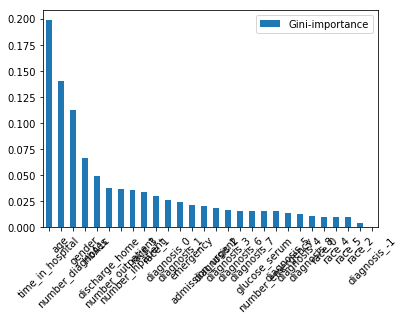

In [29]:
# Exploring the optimized parameters for the regression tree
Tree = tree.DecisionTreeClassifier()
params_tree = {"max_depth":np.arange(2,20)
              }
show_optimized_parameters(Tree, params_tree, X_train, y_train)

# Show the importance of features
tree_model = Tree.fit(X_train,y_train)
show_feature_importance(tree_model, X_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=7,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=None, splitter='best'): 0.620464
              precision    recall  f1-score   support

           0       0.63      0.89      0.74     10489
           1       0.58      0.23      0.33      7122

    accuracy                           0.62     17611
   macro avg       0.60      0.56      0.53     17611
weighted avg       0.61      0.62      0.57     17611



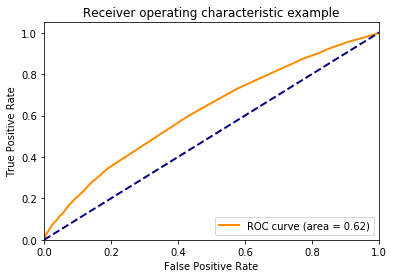

In [32]:
# Decision tree with features selected
test_model(tree.DecisionTreeClassifier(max_depth=7))

### Random forest

/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=11, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=10,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)
                   Gini-importance
time_in_hospital          0.267603
age                       0.171158
number_diagnoses          0.138947
gender                    0.045382
number_inpatient          0.042262
number_outpatient         0.041086
HbA1c                     0.037380
discharge_home            0.033440
number_emergency          0.024258
race_3                    0.016511
diagnosis_0               0.016051
race_1                    0.015463
glucose_serum             0.015099
diagnosis_2           

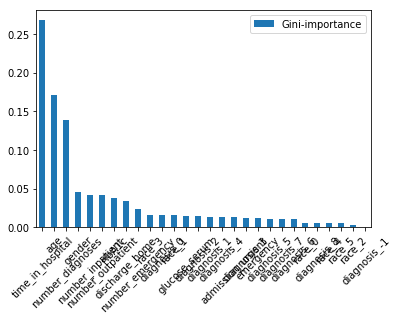

In [31]:
# Exploring the optimized parameters for the random forest
rf = ensemble.RandomForestClassifier(n_estimators=10)
params_tree = {"max_depth":np.arange(2,20)
              }
show_optimized_parameters(rf, params_tree, X_train, y_train)

# Show the importance of features
rf_model = rf.fit(X_train,y_train)
show_feature_importance(rf_model, X_train)

/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=11, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=10,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False): 0.625575
              precision    recall  f1-score   support

           0       0.63      0.89      0.74     10489
           1       0.59      0.23      0.33      7122

    accuracy                           0.63     17611
   macro avg       0.61      0.56      0.54     17611
weighted avg       0.62      0.63      0.58     17611



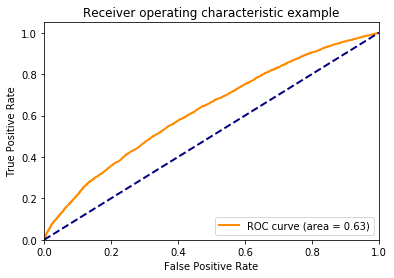

In [33]:
# Random Forests with features selected
test_model(ensemble.RandomForestClassifier(max_depth=11))

### K nearest neighbors

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=200, p=2,
                     weights='uniform'): 0.613594
              precision    recall  f1-score   support

           0       0.62      0.93      0.74     10489
           1       0.59      0.14      0.23      7122

    accuracy                           0.61     17611
   macro avg       0.60      0.54      0.48     17611
weighted avg       0.61      0.61      0.53     17611



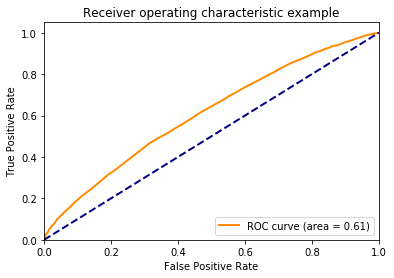

In [34]:
# KNN with features selected
test_model(neighbors.KNeighborsClassifier(n_neighbors=200))